In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import read_data as rd  # Importing the read_data.py module
from scipy.fft import fft
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

2024-06-07 07:01:53.269953: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 07:01:53.953852: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Function to normalize the data using min-max scaling
def normalize_data(data):
    min_val = np.min(data, axis=0)
    max_val = np.max(data, axis=0)
    normalized = (data - min_val) / (max_val - min_val)
    return normalized

In [3]:
# Load data
dataset_dir = '/home/ecappiell/datasets/full'
data_arrays, labels, class_ids = rd.process_mafaulda_data(dataset_dir)

In [4]:
# Original sampling rate (in Hz)
original_sampling_rate = 50 * 10**3  # 50 kHz

# Target sampling rate (in Hz)
target_sampling_rate = 2 * 10**3  # 2 kHz

# Downsample the data
downsampled_data = rd.downsample_data(data_arrays, original_sampling_rate, target_sampling_rate)

In [5]:
# Normalize the downsampled d ata
normalized_data = np.array([normalize_data(signal) for signal in downsampled_data])

In [6]:
def extract_fft_features(signal, fs, max_frequency=1000):
    N = len(signal)
    T = 1.0 / fs
    yf = fft(signal)
    xf = np.fft.fftfreq(N, T)[:N//2]
    yf = 2.0/N * np.abs(yf[:N//2])
    
    # Find the index corresponding to the maximum frequency
    max_index = int(max_frequency * N / fs)
    
    fft_features = yf[:max_index]
    return fft_features

In [7]:
# Extract FFT features for each signal up to 500 Hz
X = []
for signal in normalized_data:
    fft_features = np.array([extract_fft_features(signal[:, i], target_sampling_rate*5) for i in range(8)])
    X.append(fft_features)
X = np.array(X)

In [8]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, class_ids, test_size=0.2, random_state=37)

In [9]:
def create_model(input_shape, num_classes):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(128, activation='relu'),
        Dropout(0.4),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [10]:
input_shape = X_train.shape[1:]
num_classes = len(np.unique(class_ids))
model = create_model(input_shape, num_classes)

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/home/ecappiell/dev/.venv/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-06-07 07:03:50.454522: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-07 07:03:50.553663: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-07 07:03:50.

In [11]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, verbose=1)

Epoch 1/20


I0000 00:00:1717743831.594426   33537 service.cc:145] XLA service 0x7f89b0009fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717743831.594447   33537 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2024-06-07 07:03:51.663042: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-07 07:03:51.860148: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 1/20 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.1094 - loss: 1.8074

I0000 00:00:1717743833.757040   33537 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - accuracy: 0.2019 - loss: 1.7467 - val_accuracy: 0.2885 - val_loss: 1.6087
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2650 - loss: 1.6179 - val_accuracy: 0.3045 - val_loss: 1.5468
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3371 - loss: 1.5299 - val_accuracy: 0.5192 - val_loss: 1.3828
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5193 - loss: 1.3002 - val_accuracy: 0.6378 - val_loss: 1.1275
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5993 - loss: 1.0365 - val_accuracy: 0.7308 - val_loss: 0.9134
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7191 - loss: 0.7868 - val_accuracy: 0.7308 - val_loss: 0.7582
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8126 - loss: 0.5822 - val_accuracy: 0.8077 - val_loss: 0.6245
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8799 - loss: 0.4223 - val_accuracy: 0.8173 - val_loss: 0.5398
E

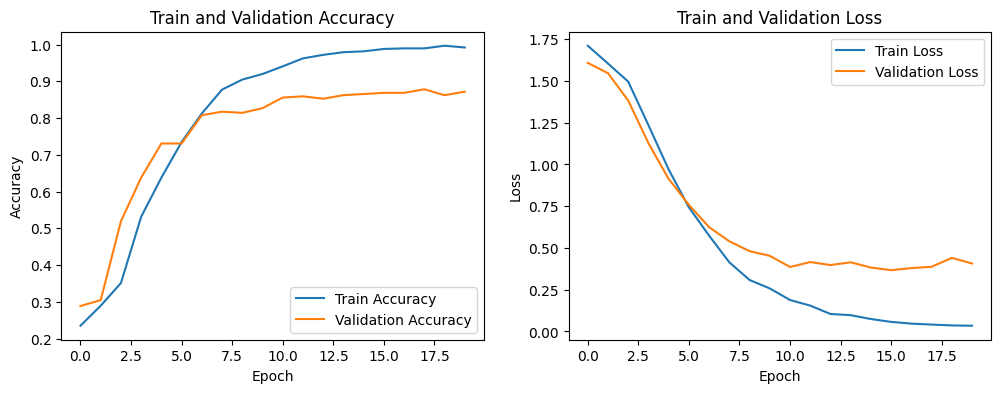

In [12]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Train and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Train and Validation Loss')

plt.show()

In [13]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred_classes)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Accuracy: 0.8670
Precision: 0.8649
Recall: 0.8670
F1 Score: 0.8654


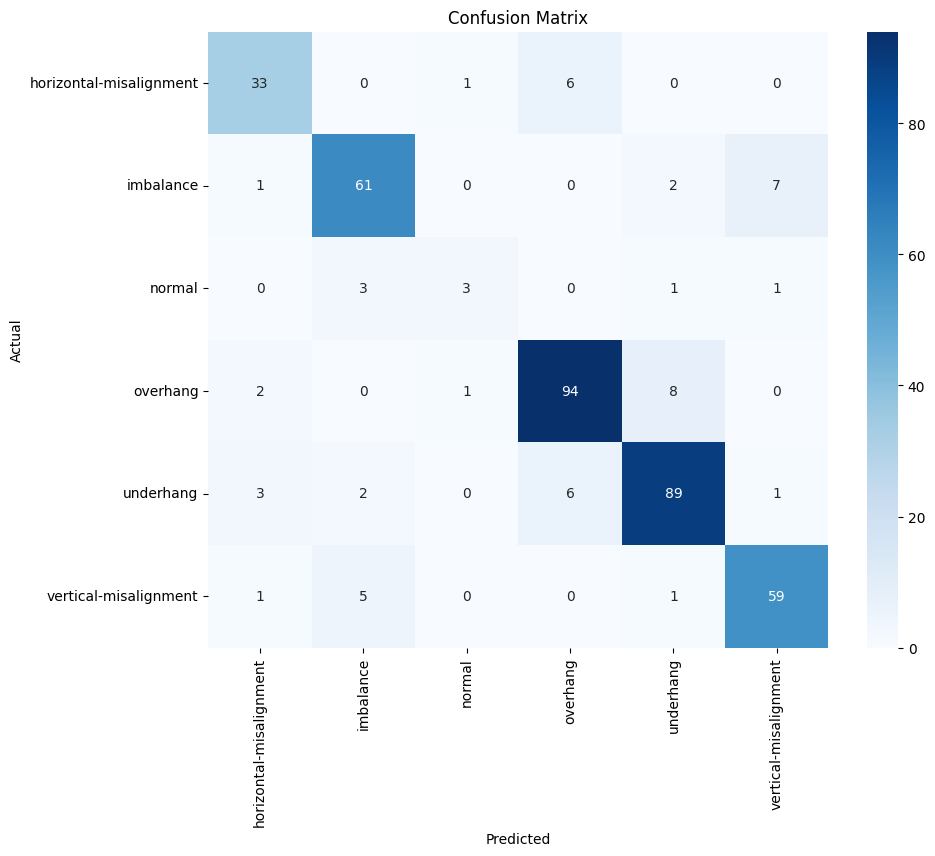

In [14]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()